In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
from matplotlib.pyplot import subplots, style, rc, rc_context
from tqdm import tqdm
from venn import venn, pseudovenn
from collections import defaultdict
from itertools import count, islice
from functools import lru_cache
from argparse import Namespace

In [2]:
from glob import glob
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import dendrogram, fcluster, linkage
from sklearn.metrics import silhouette_score
from matplotlib.gridspec import GridSpec
%matplotlib inline

In [3]:
from scipy.cluster.hierarchy import cophenet
from scipy.stats import pearsonr

In [4]:
from edgecaselib.formats import load_index, load_kmerscan
from edgecaselib.densityplot import interpret_arguments
from pickle import dump, load
from os import path
from tempfile import NamedTemporaryFile
from subprocess import check_output, CalledProcessError
from pysam import AlignmentFile
from scipy.stats import chi2_contingency
from statsmodels.stats.multitest import multipletests
from scipy.ndimage import uniform_filter1d

In [5]:
SAMFILTERS = ["is_q|tract_anchor", 3844, 0]
ecx = load_index("assets/hg38ext.fa.ecx")

In [6]:
SUBJECT_TO_TRIO = {
    "HG001": "NA12878",
    "HG002": "AshkenazimTrio", "HG003": "AshkenazimTrio", "HG004": "AshkenazimTrio",
    "HG005": "ChineseTrio", "HG006": "ChineseTrio", "HG007": "ChineseTrio",
}

In [7]:
RAW_GLOBAL_LDS = {
    re.sub(r'-matrix\.tsv$', "", filename.split("/")[-1]): pd.read_csv(filename, sep="\t", index_col=0)
    for filename in glob("PacBio/haplotypes/levenshtein-q_arm/*-matrix.tsv")
}

In [94]:
KMERSCANNER_PKL = "PacBio/kmerscanner-q_arm.pkl"
KMERSCANNER_DAT = "PacBio/kmerscanner-q_arm.dat.gz"

if path.isfile(KMERSCANNER_PKL):
    with open(KMERSCANNER_PKL, mode="rb") as pkl:
        DENSITIES = load(pkl)
else:
    DENSITIES = load_kmerscan(KMERSCANNER_DAT, True, SAMFILTERS, 10)
    with open(KMERSCANNER_PKL, mode="wb") as pkl:
        dump(DENSITIES, pkl)

In [9]:
MAXLEN = 1700

In [10]:
class GridFig():

    def __init__(self, width_ratios, height_ratios, scale=1):
        self.figure, _ = subplots(
            figsize=(sum(width_ratios)*scale, sum(height_ratios)*scale),
            ncols=0, nrows=0,
        )
        self.gs = GridSpec(
            ncols=len(width_ratios), wspace=0, width_ratios=width_ratios, 
            nrows=len(height_ratios), hspace=0, height_ratios=height_ratios,
            figure=self.figure,
        )
 
    def subplot(self, gridspec_slice, aspect="auto", frame=False):
        ax = self.figure.add_subplot(gridspec_slice, aspect=aspect)
        if frame is False:
            ax.set(frame_on=False)
        else:
            for spine in {"top", "right", "bottom", "left"} - set(frame):
                ax.spines[spine].set_visible(False)
        return ax

In [11]:
def plot_dendrogram(Z, gf):
    ax = gf.subplot(gf.gs[0,0])
    with rc_context({"lines.linewidth": .5}):
        dendrogram(
            Z, orientation="left",
            link_color_func=lambda x: "black", ax=ax,
        )
    ax.set(
        xticks=[], xlabel=None,
        yticks=[], ylabel=None,
        ylim=ax.get_ylim()[::-1],
    )

In [12]:
def plot_heatmap(data2d, gf, cmap="gray_r", vmax=.15):
    ax = gf.subplot(gf.gs[0,1])
    sns.heatmap(data2d, cmap=cmap, cbar=False, vmin=0, vmax=vmax, ax=ax)
    ax.set(xticks=[], yticks=[], xlabel=None, ylabel=None)

In [13]:
def cluster(lds, metric="correlation", method="ward"):
    Z = linkage(squareform(lds), metric=metric, method=method, optimal_ordering=True)
    leaves = dendrogram(Z, no_plot=True)["leaves"]
    data2d = lds.iloc[leaves, leaves].copy()
    dispatcher = pd.DataFrame(index=data2d.index)
    dispatcher.index.name = "read"
    to_subject = dispatcher.index.map(lambda s: s.split(":")[1])
    for subject in sorted(to_subject.drop_duplicates()):
        dispatcher[subject] = (to_subject==subject)
    return Z, data2d, dispatcher

In [14]:
def get_plottable_density_section(densities, chrom, motif, data2d, ecx):
    chrom_densities = densities[chrom]
    if motif is None:
        by_motif = chrom_densities[chrom_densities["motif"]=="TTAGGG"]
    else:
        by_motif = chrom_densities[chrom_densities["motif"]==motif]
    section = by_motif.set_index("name").reindex(data2d.index).iloc[:,8:].copy()
    if motif is None:
        section = (~section.isnull()).astype(int) / 3
    section.columns = section.columns.astype(int)
    anchor = ecx.loc[
        (ecx["rname"]==chrom) & (ecx["flag"]==0x4000) & (ecx["prime"]==3),
        "pos",
    ].iloc[0]
    return section[[c for c in section.columns if c>=anchor]]

In [15]:
def get_absentees(lds, densities, chrom, ecx):
    raw_section = get_plottable_density_section(densities, chrom, "TTAGGG", lds, ecx)
    nulls = raw_section.isnull().all(axis=1)
    return nulls[nulls].index

In [16]:
def section_to_RGB(ps, color, alpha_factor=1.2):
    return np.transpose(
        np.array([
            np.full_like(ps, color[0]),
            np.full_like(ps, color[1]),
            np.full_like(ps, color[2]),
            np.clip(ps*alpha_factor, a_min=None, a_max=1),
        ]),
        axes=(1, 2, 0),
    )

In [17]:
TRIO_COLORS = {
    "HG001": "black",
    "HG002": "green", "HG003": "green", "HG004": "green",
    "HG005": "steelblue", "HG006": "steelblue", "HG007": "steelblue",
}

In [18]:
def plot_subjects(dispatcher, gf, s=10):
    for i, subject in enumerate(sorted(SUBJECT_TO_TRIO)):
        sax = gf.subplot(gf.gs[0,i+3])
        sax.plot([0, 0], [0, len(dispatcher)], lw=.5, color="#888")
        if subject in dispatcher:
            truthiness = dispatcher[subject].reset_index(drop=True)
            positions = truthiness[truthiness].index
            for x in [-.1, 0, .1]:
                sax.scatter(x=[x]*len(positions), y=positions, marker="_", s=s, color=TRIO_COLORS[subject])
        sax.set(
            xticks=[0], xticklabels=[subject],
            yticks=[], xlabel=None, ylabel=None,
            xlim=(-.5, .5),
            ylim=(len(dispatcher), -1),
        )
        for tick in sax.get_xticklabels():
            tick.set_rotation(90)
        sax.tick_params(axis="both", which="both", length=0)

In [19]:
IMSHOW_PALETTE = {
    None: [.7, .7, .7],
    "TTAGGG": [.1, .5, .2],
    "TGAGGG": [1, 1, 0],
    "TTGGGG": [.6, .27, .5],
    "TTAGGGG": [.5, .13, 1],
}

In [20]:
def plot_densities(densities, chrom, data2d, ecx, gf, extent, bin_size=100):
    ax = gf.subplot(gf.gs[0,-1])
    for motif, color in IMSHOW_PALETTE.items():
        ps = get_plottable_density_section(densities, chrom, motif, data2d, ecx).values
        breakat = ps.shape[1]//100
        if ps.shape[1] < MAXLEN:
            ps = np.pad(ps, ((0, 0), (0, MAXLEN-ps.shape[1])))
        pa = section_to_RGB(np.clip(uniform_filter1d(ps, 5, 1), a_min=0.0, a_max=1.0), color, 1.5)
        ax.imshow(pa, extent=extent, interpolation="nearest")
    ticklabels=np.linspace(0, MAXLEN//100, MAXLEN//100+1).astype(int).astype(str)
    ticklabels[breakat+1:] = ""
    xmin, xmax = extent[:2]
    ax.set(
        xticks=np.linspace(xmin, xmax, MAXLEN//100+1),
        xticklabels=ticklabels,
        xlabel="Kbp of telomeric tract",
        yticks=[], ylabel=None,
    )
    ax.tick_params(axis="both", which="both", length=0)
    ax.axhline(0, 0, (breakat+1)/len(ticklabels), lw=.5, c="black")

In [29]:
def process_lds(raw_global_lds, chrom, densities, ecx):
    lds = raw_global_lds[chrom].copy()
    absentees = get_absentees(lds, densities, chrom, ecx)
    lds.drop(index=absentees, columns=absentees, inplace=True)
    Z, data2d, dispatcher = cluster(lds, metric="euclidean", method="ward")
    h = 6*len(lds)/200
    w = 30
    gf = GridFig([h/3,h,.3]+[.5]*7+[w], [h], scale=.4)
    plot_dendrogram(Z, gf=gf)
    plot_heatmap(data2d, gf=gf)
    plot_subjects(dispatcher, gf=gf, s=7)
    plot_densities(densities, chrom, data2d, ecx, gf=gf, extent=[0,w,0,h])
    match = re.search(r'^\d+', chrom)
    if match:
        name = "chr{} ({})".format(match.group(), chrom)
    else:
        name = chrom
    gf.figure.get_axes()[0].set(ylabel=name)
    return lds, Z, data2d, dispatcher, gf

In [22]:
def run_mmc(df):
    """ Use either:
          * pymmc-pipeline from http://mmc.gnets.ncsu.edu/ and Python2
          * our internal py3 fork and Python3
    """
    with NamedTemporaryFile(mode="wt", dir=".") as csv_in:
        with NamedTemporaryFile(mode="wt", dir=".") as tsv_out:
            df.to_csv(csv_in, sep=",")
            check_output([
                "python", "pymmc-pipeline/run-mmc.py",
                "--csv-in", path.split(csv_in.name)[1],
                "--clustered-out", path.split(tsv_out.name)[1],
            ])
            dataframe_clustering = pd.read_csv(
                tsv_out.name, sep="\t", index_col=[0,1], header=[0,1],
            )
    return dataframe_clustering

In [34]:
def cluster_mmc(lds):
    mmc = run_mmc(lds)
    mmc_dispatcher = mmc.index.to_frame().droplevel(1, 0).iloc[:,[1]]
    mmc_dispatcher.index.name = "read"
    mmc_dispatcher["subject"] = mmc_dispatcher.index.map(lambda s: s.split(":")[1])
    counts = mmc_dispatcher.reset_index().groupby(["cluster", "subject"], as_index=False)["read"].count()
    contmat = counts.pivot(index="cluster", columns="subject", values="read").fillna(0).astype(int)
    read_order = mmc.index.get_level_values(0)
    data2mmc = lds.loc[read_order, read_order].copy()
    return mmc, data2mmc, contmat

In [32]:
def cophenetic_correlation(lds, Z):
    r, p = pearsonr(squareform(lds), cophenet(Z))
    return r, max(p, 5e-324) # p-value of zero is just a rounding issue

In [30]:
def fixup_labels(gf, chrom):
    if chrom == "5qtel_1-500K_1_12_12_rc":
        gf.figure.get_axes()[1].set(title="Pairwise relative Levenshtein distances")
        gf.figure.get_axes()[5].set(title="Subjects")
        gf.figure.get_axes()[-1].set_title("   Motif densities", loc="left")
    if chrom != "chrX":
        for ax in gf.figure.get_axes()[:-1]:
            ax.set(xticklabels=[], xlabel=None)
        gf.figure.get_axes()[-1].set(xlabel=None)
    if chrom == "16qtel_1-500K_1_12_12_rc":
        gf.figure.get_axes()[0].set(ylabel="chr16 (...)")
    if chrom == "14qtel_1-500K_1_12_12_rc":
        gf.figure.get_axes()[0].set(ylabel="chr14 (14qtel...)")

100%|██████████| 18/18 [08:45<00:00, 29.19s/it]


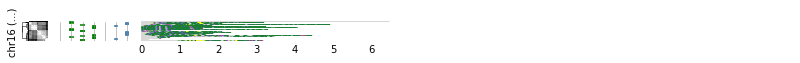

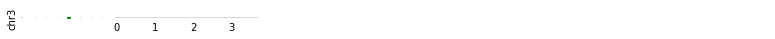

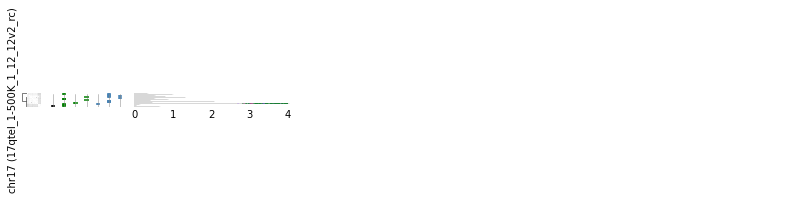

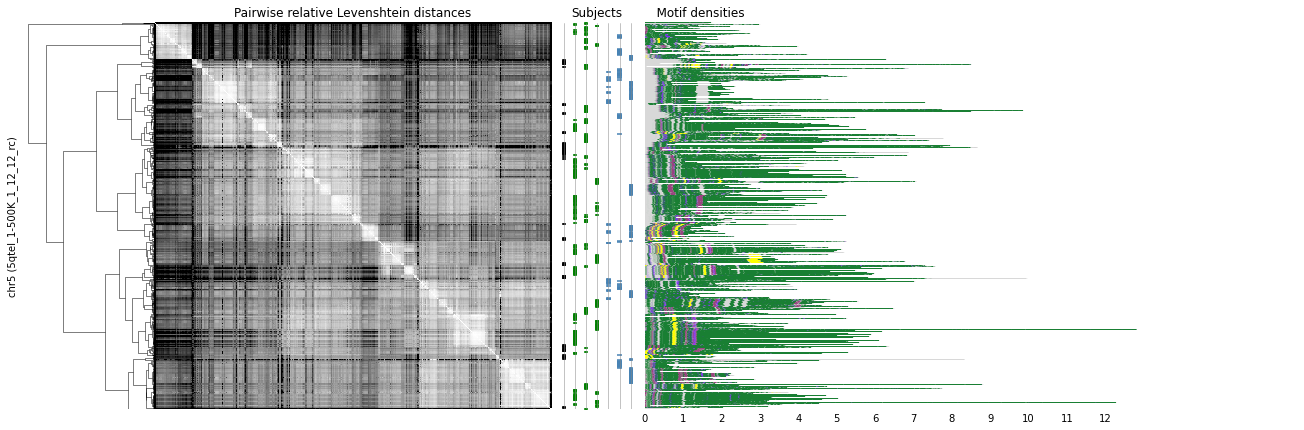

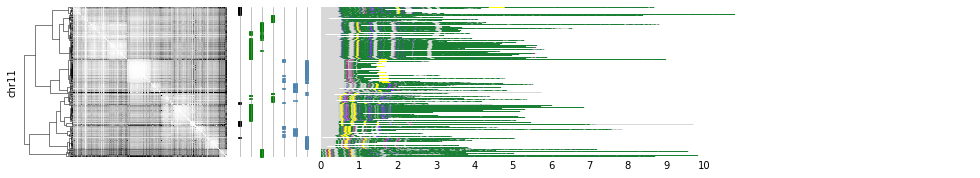

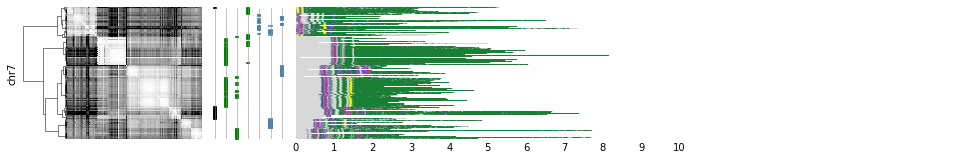

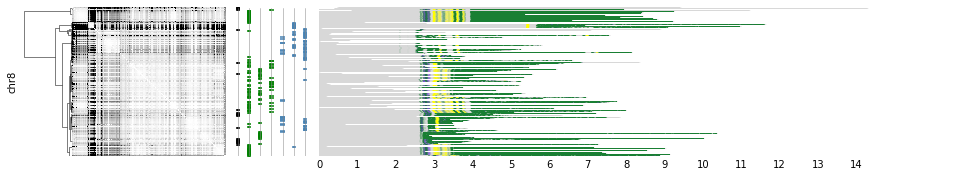

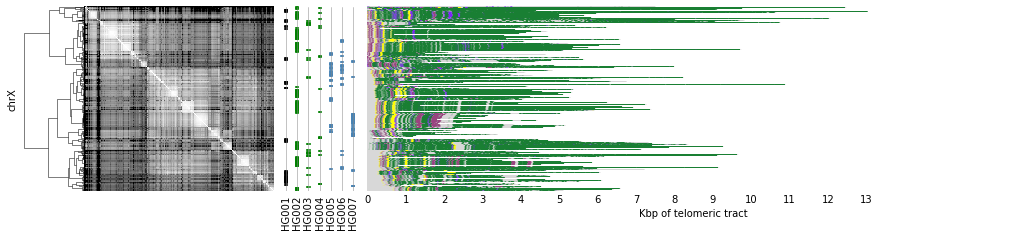

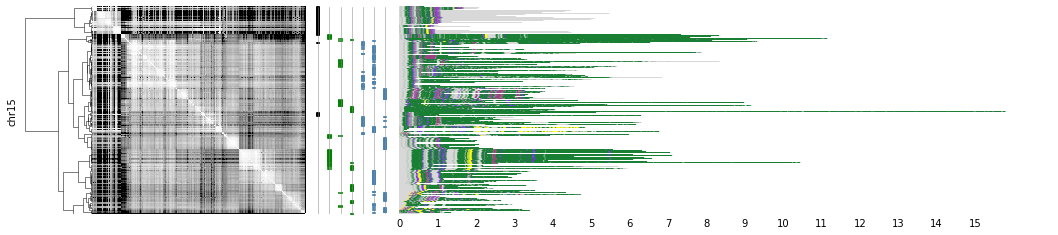

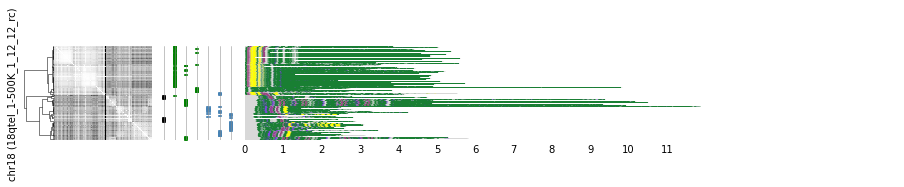

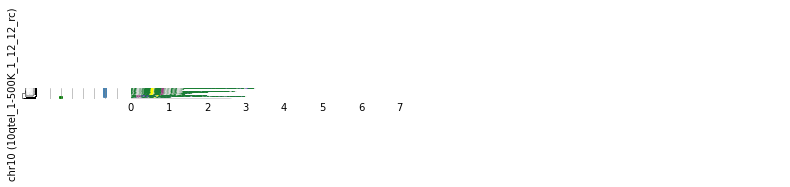

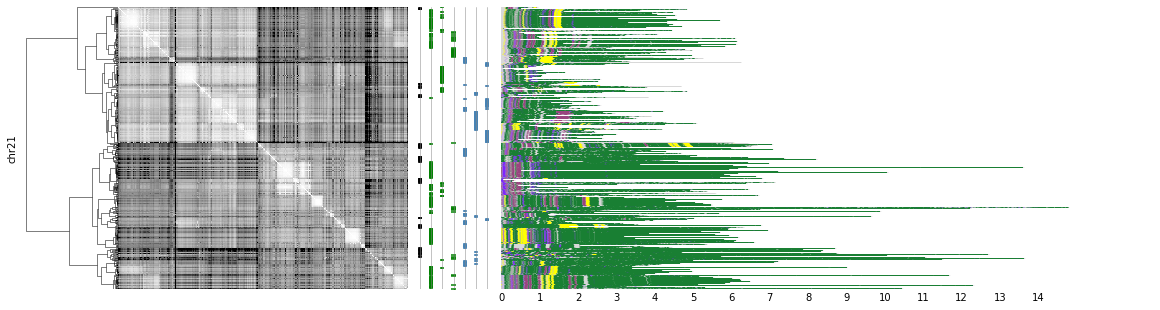

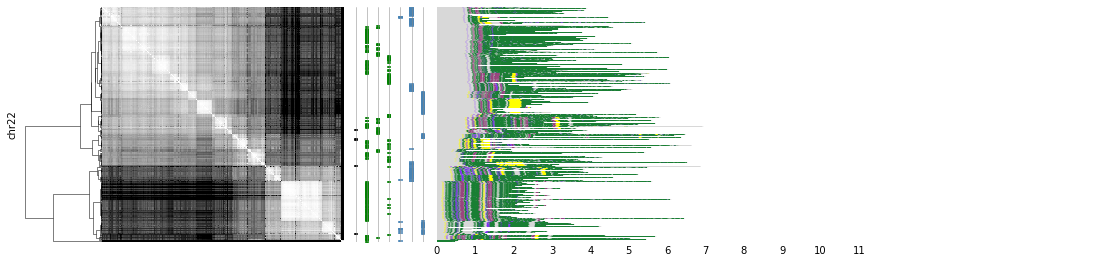

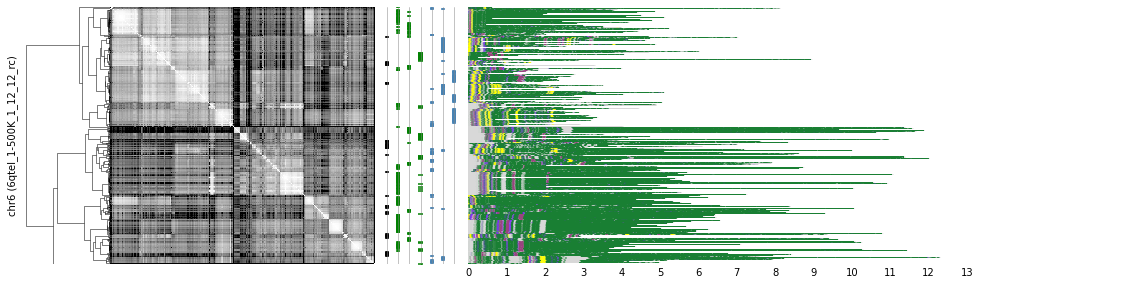

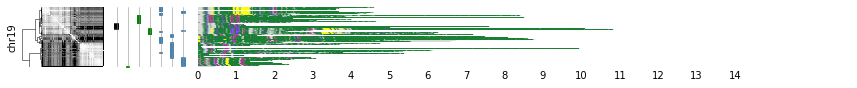

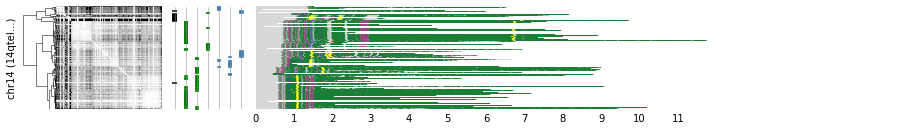

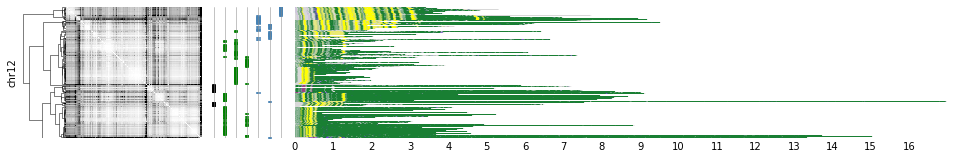

In [43]:
stats = pd.DataFrame(columns=["cr", "cp", "n_clusters", "score", "p", "nspc"])
contmats = []

for chrom in tqdm(RAW_GLOBAL_LDS):
    try:
        lds, Z, data2d, dispatcher, gf = process_lds(RAW_GLOBAL_LDS, chrom, DENSITIES, ecx)
        ns = Namespace(lds=lds, Z=Z, data2d=data2d, dispatcher=dispatcher, gf=gf)
        with open("PacBio/haplotypes/clusters-q_arm/"+chrom+".pkl", mode="wb") as pkl:
            dump(ns, pkl)
    except ValueError: # too few observations
        continue
    try:
        mmc, data2mmc, contmat = cluster_mmc(lds)
    except (CalledProcessError, FileNotFoundError): # too few observations or pymmc not found
        pval, n_clusters, n_subjects_per_cluster, score = np.nan, np.nan, np.nan, np.nan
    else:
        pval = chi2_contingency(contmat)[1]
        n_clusters = len(contmat)
        n_subjects_per_cluster = (contmat > 0).sum(axis=1).tolist()
        labels = mmc.index.get_level_values(1).tolist()
        score = silhouette_score(data2mmc, labels)
        contmat["chromosome"] = chrom
        contmats.append(contmat)
    try:
        cr, cp = cophenetic_correlation(lds, Z)
    except ValueError: # too few observations
        cr, cp = np.nan, np.nan
    fixup_labels(gf, chrom)
    gf.figure.savefig("PacBio/haplotypes/clusters-q_arm/"+chrom+".pdf", bbox_inches="tight")
    stats.loc[chrom] = [cr, cp, n_clusters, score, pval, n_subjects_per_cluster]

In [39]:
def convname(cn):
    match = re.search(r'^\d+', cn)
    if match:
        return "chr" + match.group()
    else:
        return cn

In [70]:
stats["cp"] = multipletests(stats["cp"], method="bonferroni")[1]
stats["p"] = multipletests(stats["p"], method="bonferroni")[1]
finalstats = stats.drop(columns=["nspc"]).copy()
finalstats.index.name = "contig_name"
finalstats.reset_index(inplace=True)

finalstats.insert(0, "chromosome", finalstats["contig_name"].apply(convname))
finalstats = finalstats.sort_values(by="chromosome").dropna()
finalstats.to_csv("clustering-stats.tsv", sep="\t", index=False)
finalstats

,chromosome,contig_name,cr,cp,n_clusters,score,p
4,chr11,chr11,0.435145,5.859020e-313,11,0.247582,1.724606e-71
16,chr12,chr12,0.395061,5.859020e-313,20,0.095909,2.367387e-74
15,chr14,14qtel_1-500K_1_12_12_rc,0.620025,5.859020e-313,20,0.097280,6.250336e-19
8,chr15,chr15,0.456952,5.859020e-313,40,0.193553,1.011933e-111
0,chr16,16qtel_1-500K_1_12_12_rc,0.747151,9.271114e-68,2,0.482653,1.000000e+00
2,chr17,17qtel_1-500K_1_12_12v2_rc,0.977346,3.586712e-131,3,-0.060189,1.000000e+00
9,chr18,18qtel_1-500K_1_12_12_rc,0.520010,5.859020e-313,15,0.110245,3.455691e-44
14,chr19,chr19,0.520305,2.068029e-284,10,0.047420,2.182452e-15
11,chr21,chr21,0.387948,5.859020e-313,48,0.147068,9.640935e-148
12,chr22,chr22,0.567914,5.859020e-313,18,0.154333,1.108253e-91


In [71]:
mini_cluster_stats = pd.concat([c.reset_index() for c in contmats], sort=False).reset_index(drop=True).fillna(0)
mini_cluster_stats.rename(columns={"chromosome": "contig_name"}, inplace=True)
mini_cluster_stats["chromosome"] = mini_cluster_stats["contig_name"].apply(convname)
for s in SUBJECT_TO_TRIO:
    mini_cluster_stats[s] = mini_cluster_stats[s].astype(int)
mini_cluster_stats["cluster_size"] = mini_cluster_stats[sorted(SUBJECT_TO_TRIO)].sum(axis=1)
mini_cluster_stats = mini_cluster_stats[["chromosome", "contig_name", "cluster", "cluster_size"]+sorted(SUBJECT_TO_TRIO)]
mini_cluster_stats = mini_cluster_stats.sort_values(by="chromosome")
mini_cluster_stats.to_csv("mini-cluster-stats.tsv", sep="\t", index=False)
mini_cluster_stats.sort_values(by="cluster_size", ascending=False)

,chromosome,contig_name,cluster,cluster_size,HG001,HG002,HG003,HG004,HG005,HG006,HG007
252,chr22,chr22,6,72,0,38,7,17,1,9,0
66,chr11,chr11,10,39,7,10,0,7,7,7,1
253,chr22,chr22,7,39,0,10,7,10,1,11,0
22,chr5,5qtel_1-500K_1_12_12_rc,17,38,0,2,0,5,0,7,24
101,chr8,chr8,14,38,0,6,16,15,1,0,0
57,chr11,chr11,1,37,0,1,0,1,1,3,31
62,chr11,chr11,6,37,0,8,21,7,1,0,0
97,chr8,chr8,10,35,3,28,4,0,0,0,0
38,chr5,5qtel_1-500K_1_12_12_rc,33,35,0,27,1,6,0,1,0
84,chr7,chr7,17,33,0,0,0,9,7,9,8
